#Preparing the dataset

In [1]:
import logging

In [2]:
import time

In [3]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [4]:
# # !pip install --upgrade simpletransformers
# !pip install transformers==4.24.0
# from simpletransformers.classification import (
#     ClassificationModel, ClassificationArgs
# )

Import relevant tools

In [5]:
from prettytable import PrettyTable

In [6]:
from sklearn.model_selection import cross_val_predict

In [7]:
!pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [8]:
from scipy.sparse import csr_matrix

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [10]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Upload the annotated news comment data and news content data

In [11]:
# from google.colab import files
# !ls
# !rm * # helps when we rerun the whole code for any reason. (refreshes the data)
# uploaded = files.upload()

Check data

In [12]:
# df = pd.read_excel('internship_ml_data3.xlsx')

df = pd.read_excel('https://raw.githubusercontent.com/Alcoris0987/DTA-Thesis/main/internship_ml_data3.xlsx')
df

,news,articlkey,body,Support,Personal,Suggestion,Alternate View,Question,Irrelevant
0,guardian,/p/jpnd3,Staying Power- Peter Fryer,0.0,0.0,1.0,0,0.0,0.0
1,guardian,/p/jpnd3,No Strong Female Lead by Arwa Mahdawi? Very ea...,0.0,0.0,1.0,0,1.0,0.0
2,guardian,/p/jpnd3,Nice selection. Stuff about Africa and Nigeria...,1.0,1.0,0.0,0,1.0,0.0
3,guardian,/p/jpnd3,"An interesting collection, but seemingly mostl...",0.0,0.0,1.0,1,0.0,0.0
4,guardian,/p/jpnd3,"If we want to explain the world, we should als...",0.0,0.0,1.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1236,washingtonpost,20181114,The player’s action was outrageous and dangero...,1.0,0.0,1.0,1,0.0,0.0
1237,washingtonpost,20181114,He lost his cool! He was frustrated! All BS! T...,0.0,0.0,0.0,1,0.0,0.0
1238,washingtonpost,20181114,"I played basketball for nearly thirty years, u...",0.0,1.0,0.0,0,0.0,0.0
1239,washingtonpost,20181114,Too many below consider this a hate crime. I d...,0.0,0.0,1.0,0,0.0,0.0


Check if values are binary

In [13]:
pd.unique(df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].values.ravel('K'))

array([ 0.,  1., nan])

Change nan to 0 and convert the values to integers

In [14]:
df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']] = df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].fillna(0)
pd.unique(df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].values.ravel('K'))

array([0., 1.])

In [15]:
df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']] = df[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].astype(int)
df

,news,articlkey,body,Support,Personal,Suggestion,Alternate View,Question,Irrelevant
0,guardian,/p/jpnd3,Staying Power- Peter Fryer,0,0,1,0,0,0
1,guardian,/p/jpnd3,No Strong Female Lead by Arwa Mahdawi? Very ea...,0,0,1,0,1,0
2,guardian,/p/jpnd3,Nice selection. Stuff about Africa and Nigeria...,1,1,0,0,1,0
3,guardian,/p/jpnd3,"An interesting collection, but seemingly mostl...",0,0,1,1,0,0
4,guardian,/p/jpnd3,"If we want to explain the world, we should als...",0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1236,washingtonpost,20181114,The player’s action was outrageous and dangero...,1,0,1,1,0,0
1237,washingtonpost,20181114,He lost his cool! He was frustrated! All BS! T...,0,0,0,1,0,0
1238,washingtonpost,20181114,"I played basketball for nearly thirty years, u...",0,1,0,0,0,0
1239,washingtonpost,20181114,Too many below consider this a hate crime. I d...,0,0,1,0,0,0


Create a column with all the labels in one place.

In [16]:
df['binary_terms'] = df.apply(lambda x: x.values[3:], axis = 1)
df

,news,articlkey,body,Support,Personal,Suggestion,Alternate View,Question,Irrelevant,binary_terms
0,guardian,/p/jpnd3,Staying Power- Peter Fryer,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
1,guardian,/p/jpnd3,No Strong Female Lead by Arwa Mahdawi? Very ea...,0,0,1,0,1,0,"[0, 0, 1, 0, 1, 0]"
2,guardian,/p/jpnd3,Nice selection. Stuff about Africa and Nigeria...,1,1,0,0,1,0,"[1, 1, 0, 0, 1, 0]"
3,guardian,/p/jpnd3,"An interesting collection, but seemingly mostl...",0,0,1,1,0,0,"[0, 0, 1, 1, 0, 0]"
4,guardian,/p/jpnd3,"If we want to explain the world, we should als...",0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...
1236,washingtonpost,20181114,The player’s action was outrageous and dangero...,1,0,1,1,0,0,"[1, 0, 1, 1, 0, 0]"
1237,washingtonpost,20181114,He lost his cool! He was frustrated! All BS! T...,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0]"
1238,washingtonpost,20181114,"I played basketball for nearly thirty years, u...",0,1,0,0,0,0,"[0, 1, 0, 0, 0, 0]"
1239,washingtonpost,20181114,Too many below consider this a hate crime. I d...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"


Check news content data

In [17]:
newscontent = pd.read_excel('https://raw.githubusercontent.com/Alcoris0987/DTA-Thesis/main/newscontent.xlsx')
newscontent = dict((v, k,) for k, v in newscontent.values)
newscontent

{'/p/jpnd3': 'Books that explain the world: Guardian writers share their best nonfiction reads of the year From a Jacobean traveller’s travails in Sindh to the tangled roots of Nigeria, our pick of new nonfiction books that shine a light on Asia, Africa and South America\n\nShare your top recommendations for books on the developing world in the comments below\nGlobal development is supported by\nBill and Melinda Gates Foundation\nAbout this content\nGuardian writers\nWed 15 Dec 2021 10.21 GMT\nLast modified on Fri 17 Dec 2021 08.37 GMT\n\n66\nEgypt\n\nYou Have Not Yet Been Defeated: Selected Works 2011-2021\nBy Alaa Abd El-Fattah\nCover of You Have Not Yet Been Defeated\n‘The text you are holding is living history,’ writes Naomi Klein in her foreword to Alaa Abd El-Fattah’s book. Photograph: Courtesy of Fitzcarraldo\n\nIn a totalitarian system where even ideas are punishable with imprisonment, this collection of essays from one of Egypt’s most high-profile political prisoners is like a

In [18]:
newstitle = pd.read_excel('https://raw.githubusercontent.com/Alcoris0987/DTA-Thesis/main/newstitle.xlsx')
newstitle = dict((v, k,) for k, v in newstitle.values)
newstitle

{'/p/jpnd3': 'Books that explain the world: Guardian writers share their best nonfiction reads of the year',
 '/p/kxdhg': 'Could he? Will they? What if? What might happen next in Succession',
 '/p/jzp4p': 'Rajan the last ocean-swimming elephant: Jody MacDonald’s best photograph',
 '/p/jnpmq': '‘I’ve healed. I don’t want to be the badass’ – Noomi Rapace on beating her Dragon Tattoo trauma',
 '/p/kxjjt': 'Shatner in Space: Captain Kirk’s in a willy-shaped spaceship – and it’s poetry in motion',
 '/p/k6fmd': 'I lost more than £12,000 in a scam and the Co-operative Bank won’t resolve it',
 '/p/k2cmj': 'Are we witnessing the dawn of post-theory science?',
 '/p/k8g6v': '‘A Rosetta Stone’: Australian fossil site is a vivid window into 15m-year-old rainforest',
 '/p/km74p': "I'm still repaying my repaid student loan",
 '/p/yxh6h': 'England’s new attack stutters as West Indies’ Holder and Bonner stand firm',
 'b2052032': 'Spain reverses plan to open up to unvaccinated British visitors',
 'b2051

Reference and replace the article key to create a column for the news content

In [19]:
df['content'] = df['articlkey'].map(newscontent)
df['title'] = df['articlkey'].map(newstitle)
df_filtered = df.drop(columns=['articlkey'])
df_filtered

,news,body,Support,Personal,Suggestion,Alternate View,Question,Irrelevant,binary_terms,content,title
0,guardian,Staying Power- Peter Fryer,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...
1,guardian,No Strong Female Lead by Arwa Mahdawi? Very ea...,0,0,1,0,1,0,"[0, 0, 1, 0, 1, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...
2,guardian,Nice selection. Stuff about Africa and Nigeria...,1,1,0,0,1,0,"[1, 1, 0, 0, 1, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...
3,guardian,"An interesting collection, but seemingly mostl...",0,0,1,1,0,0,"[0, 0, 1, 1, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...
4,guardian,"If we want to explain the world, we should als...",0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...
...,...,...,...,...,...,...,...,...,...,...,...
1236,washingtonpost,The player’s action was outrageous and dangero...,1,0,1,1,0,0,"[1, 0, 1, 1, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...
1237,washingtonpost,He lost his cool! He was frustrated! All BS! T...,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...
1238,washingtonpost,"I played basketball for nearly thirty years, u...",0,1,0,0,0,0,"[0, 1, 0, 0, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...
1239,washingtonpost,Too many below consider this a hate crime. I d...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...


Look for duplicates

In [20]:
total_duplicate_titles = sum(df["body"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")
# Non so far because they were cleaned before being added.

There are 0 duplicate titles.


Convert the terms to their respective labels

In [21]:
def convert(x):
    y = []
    keys = ['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']
    for k,v in zip(x, keys):
        if k == 1:
            y.append(v)
    return tuple(y)

In [22]:
df['terms'] = df['binary_terms'].apply(lambda x: convert(x))
df

,news,articlkey,body,Support,Personal,Suggestion,Alternate View,Question,Irrelevant,binary_terms,content,title,terms
0,guardian,/p/jpnd3,Staying Power- Peter Fryer,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...,"(Suggestion,)"
1,guardian,/p/jpnd3,No Strong Female Lead by Arwa Mahdawi? Very ea...,0,0,1,0,1,0,"[0, 0, 1, 0, 1, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...,"(Suggestion, Question)"
2,guardian,/p/jpnd3,Nice selection. Stuff about Africa and Nigeria...,1,1,0,0,1,0,"[1, 1, 0, 0, 1, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...,"(Support, Personal, Question)"
3,guardian,/p/jpnd3,"An interesting collection, but seemingly mostl...",0,0,1,1,0,0,"[0, 0, 1, 1, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...,"(Suggestion, Alternate View)"
4,guardian,/p/jpnd3,"If we want to explain the world, we should als...",0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Books that explain the world: Guardian writers...,Books that explain the world: Guardian writers...,"(Suggestion,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,washingtonpost,20181114,The player’s action was outrageous and dangero...,1,0,1,1,0,0,"[1, 0, 1, 1, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...,"(Support, Suggestion, Alternate View)"
1237,washingtonpost,20181114,He lost his cool! He was frustrated! All BS! T...,0,0,0,1,0,0,"[0, 0, 0, 1, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...,"(Alternate View,)"
1238,washingtonpost,20181114,"I played basketball for nearly thirty years, u...",0,1,0,0,0,0,"[0, 1, 0, 0, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...,"(Personal,)"
1239,washingtonpost,20181114,Too many below consider this a hate crime. I d...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",Division III basketball player apologizes for ...,Division III basketball player apologizes for ...,"(Suggestion,)"


Filter the rare terms to prepare them for stratification

In [23]:
df_filtered = df.groupby("terms").filter(lambda x: len(x) > 1)
df_filtered.shape

(1239, 13)

In [24]:
from collections import Counter

Turn the raw strings in 'terms' to list[str] for a more compact representation.

In [25]:
df_filtered["terms"] = df_filtered["terms"].apply(
    lambda x: list(x)
)
df_filtered["terms"].values[:5]

array([list(['Suggestion']), list(['Suggestion', 'Question']),
       list(['Support', 'Personal', 'Question']),
       list(['Suggestion', 'Alternate View']), list(['Suggestion'])],
      dtype=object)

Visualize the data


Support           190
Personal          267
Suggestion        686
Alternate View    387
Question          206
Irrelevant        119
dtype: int64


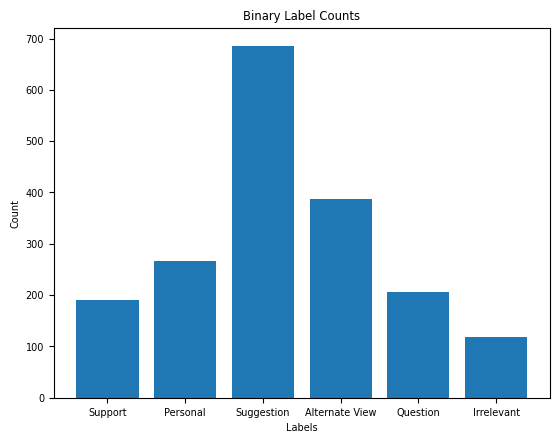

In [26]:
# Count the occurrences of each label
label_counts = df_filtered[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].sum()
print(label_counts)

# Create a bar plot
plt.rcParams.update({'font.size': 7})
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Binary Label Counts')

# Display the plot
plt.show()

Support           0.153349
Personal          0.215496
Suggestion        0.553672
Alternate View    0.312349
Question          0.166263
Irrelevant        0.096045
dtype: float64


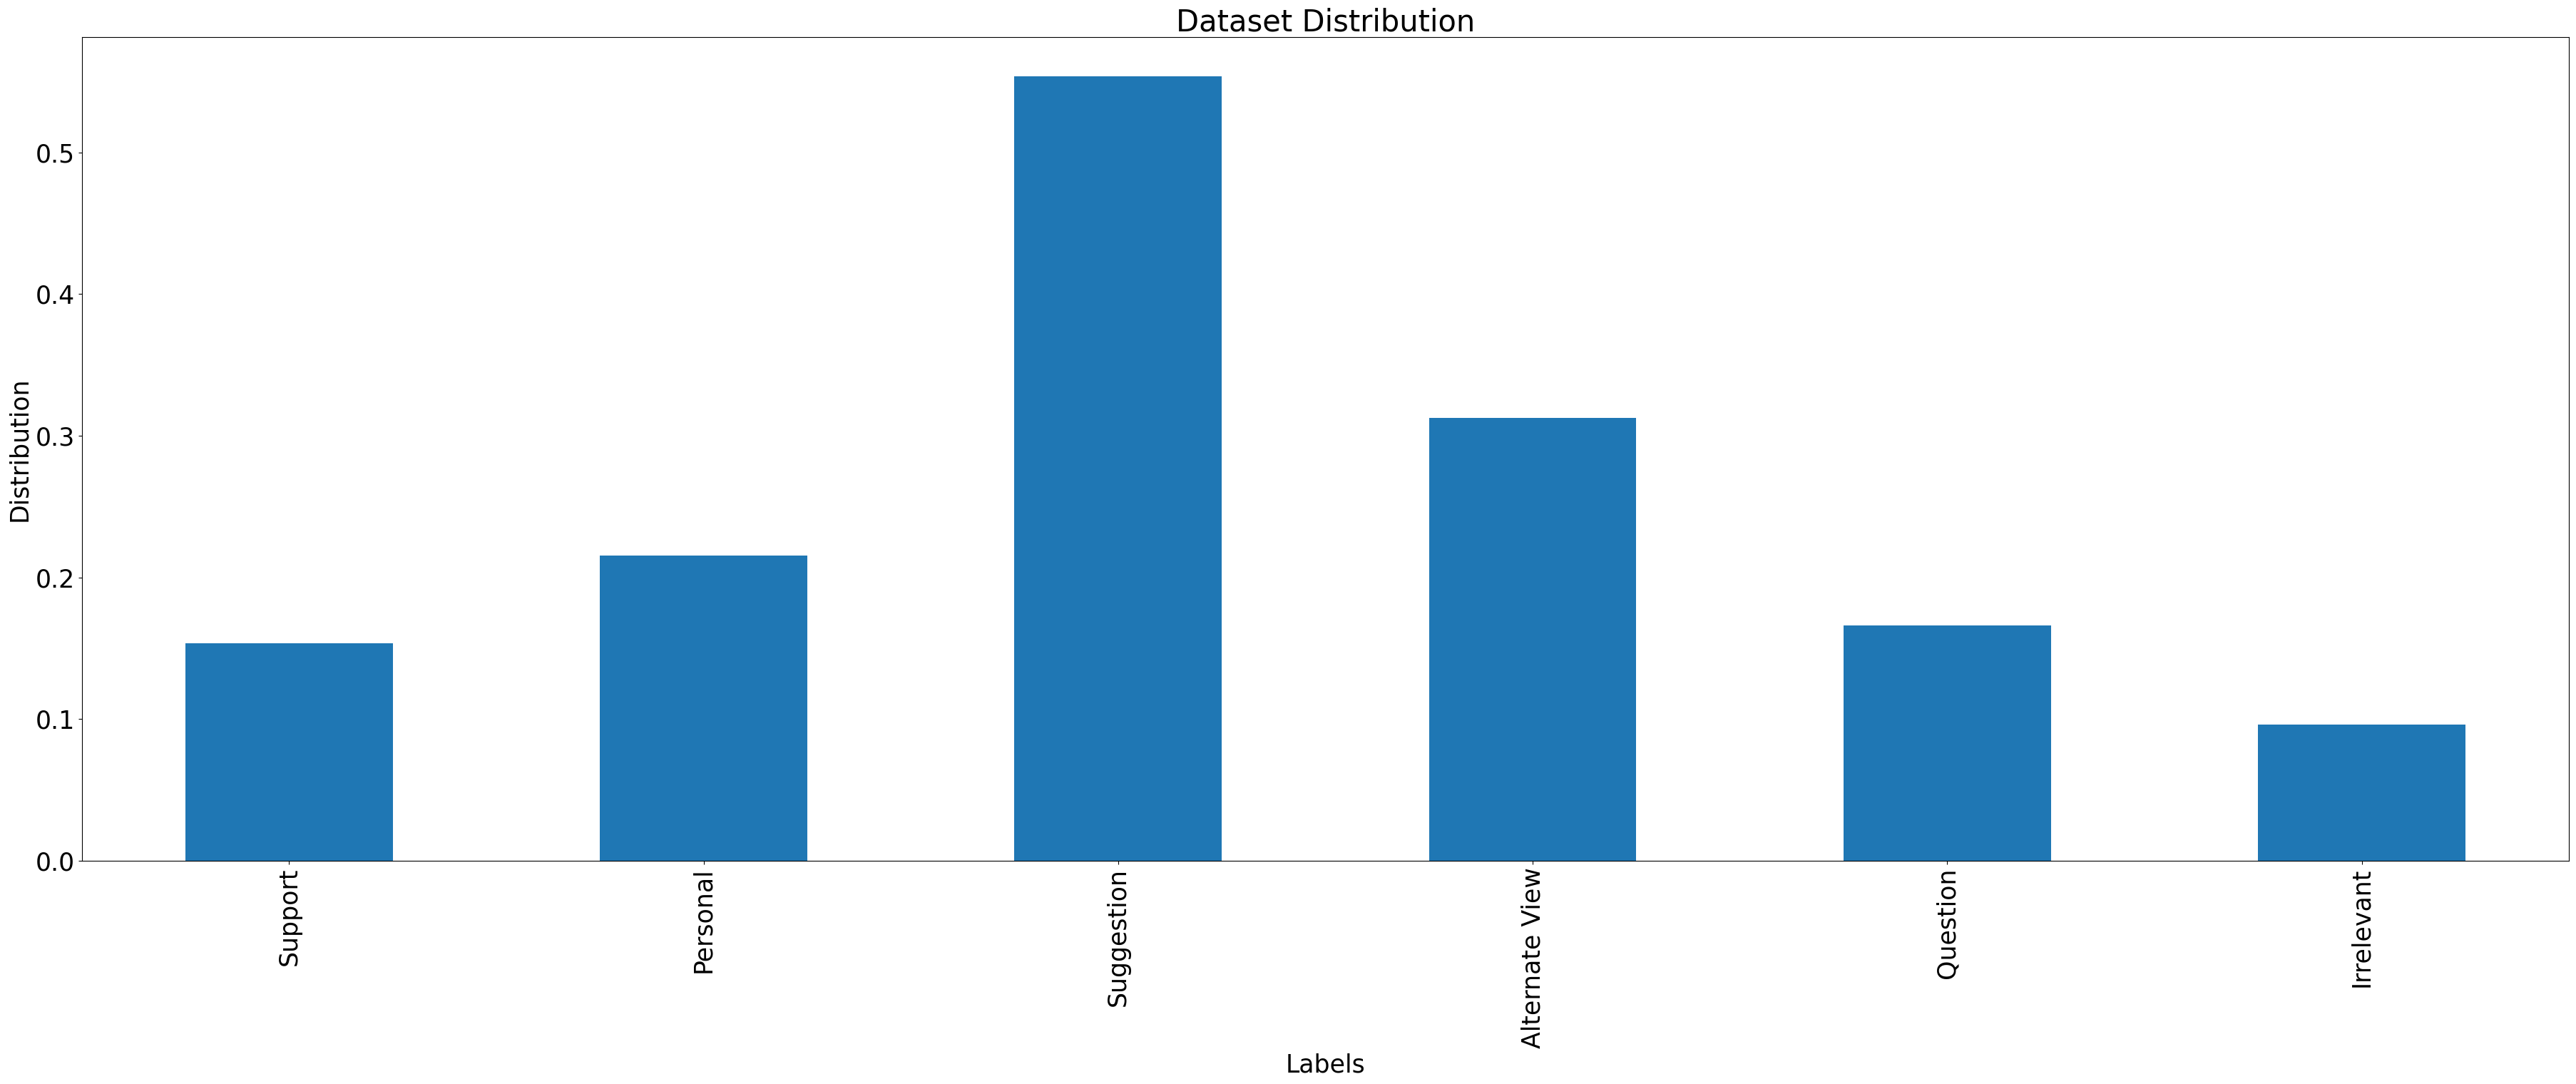

In [27]:
# Calculate the label distributions
label_distributions = df_filtered[['Support','Personal','Suggestion','Alternate View', 'Question','Irrelevant']].mean()
print(label_distributions)

# Display the plot
plt.rcParams.update({'font.size': 25})
plt.subplots(figsize=(45,15))
label_distributions.plot.bar(title="Dataset Distribution",xlabel="Labels", ylabel="Distribution");

#Import relevant tools

In [28]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random
from sklearn.svm import LinearSVC

In [29]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score

# Binary Relevance with SVC

## Preprocessing and Train Test Split

In [31]:
sentpair = df_filtered.drop(columns=['news', 'Support', 'Personal', 'Suggestion', 'Alternate View', 'Question', 'Irrelevant', 'terms'])
sentpair = sentpair[['content', 'body', 'binary_terms']]
sentpair.columns = ["text_a", "text_b", "labels"]
sent = sentpair[["text_b", "labels"]]

In [32]:
sent

,text_b,labels
0,Staying Power- Peter Fryer,"[0, 0, 1, 0, 0, 0]"
1,No Strong Female Lead by Arwa Mahdawi? Very ea...,"[0, 0, 1, 0, 1, 0]"
2,Nice selection. Stuff about Africa and Nigeria...,"[1, 1, 0, 0, 1, 0]"
3,"An interesting collection, but seemingly mostl...","[0, 0, 1, 1, 0, 0]"
4,"If we want to explain the world, we should als...","[0, 0, 1, 0, 0, 0]"
...,...,...
1236,The player’s action was outrageous and dangero...,"[1, 0, 1, 1, 0, 0]"
1237,He lost his cool! He was frustrated! All BS! T...,"[0, 0, 0, 1, 0, 0]"
1238,"I played basketball for nearly thirty years, u...","[0, 1, 0, 0, 0, 0]"
1239,Too many below consider this a hate crime. I d...,"[0, 0, 1, 0, 0, 0]"


In [33]:
train_df, test_df = train_test_split(sent, test_size=0.2, random_state=42)

In [34]:
# Reshape the labels to a 2D array
train_labels = np.array(train_df['labels'].values.tolist(), dtype=int)
test_labels = np.array(test_df['labels'].tolist(), dtype=int)

In [35]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix_train = vectorizer.fit_transform(train_df['text_b'])
tfidf_matrix_test = vectorizer.transform(test_df['text_b'])

## Prepare the Classifier

In [36]:
# Initialize the BinaryRelevance classifier with LinearSVC
classifier = BinaryRelevance(LinearSVC())

In [37]:
# Use cross_val_predict for cross-validation and predictions
num_folds = 5
val_pred_labels = cross_val_predict(classifier, tfidf_matrix_train, train_labels, cv=num_folds)

In [38]:
# Calculate evaluation metrics for each fold
fold_metrics = []
for fold in range(num_folds):
    fold_accuracy = accuracy_score(train_labels, val_pred_labels)
    fold_hamming_loss = hamming_loss(train_labels, val_pred_labels)
    fold_f1_macro = f1_score(train_labels, val_pred_labels, average='macro')
    fold_micro_precision = precision_score(train_labels, val_pred_labels, average='micro')
    fold_micro_recall = recall_score(train_labels, val_pred_labels, average='micro')

    fold_metrics.append((fold_accuracy, fold_hamming_loss, fold_f1_macro, fold_micro_precision, fold_micro_recall))

# Aggregate the metrics
mean_metrics = tuple(np.mean(metric) for metric in zip(*fold_metrics))
std_metrics = tuple(np.std(metric) for metric in zip(*fold_metrics))

In [39]:
print("Aggregated Results:")
print(f"Mean Accuracy: {mean_metrics[0]} ± {std_metrics[0]}")
print(f"Mean Hamming Loss: {mean_metrics[1]} ± {std_metrics[1]}")
print(f"Mean F1 Macro: {mean_metrics[2]} ± {std_metrics[2]}")
print(f"Mean Micro Precision: {mean_metrics[3]} ± {std_metrics[3]}")
print(f"Mean Micro Recall: {mean_metrics[4]} ± {std_metrics[4]}")

Aggregated Results:
Mean Accuracy: 0.2119071644803229 ± 0.0
Mean Hamming Loss: 0.2127480659266734 ± 0.0
Mean F1 Macro: 0.3649119470251805 ± 0.0
Mean Micro Precision: 0.6024321796071095 ± 0.0
Mean Micro Recall: 0.4339622641509434 ± 0.0


## Run the Classifier

In [40]:
# Fit the classifier to the training data
classifier.fit(tfidf_matrix_train, train_labels)

BinaryRelevance(classifier=LinearSVC(), require_dense=[True, True])

In [41]:
# Predict labels for the test data whil recording runtime
start_time = time.time()
predictions = classifier.predict(tfidf_matrix_test)
end_time = time.time()

In [42]:
# Evaluate the predictions
accuracy_score_value = accuracy_score(test_labels, predictions)
hamming_loss_value = hamming_loss(test_labels, predictions)
f1_micro = f1_score(test_labels, predictions, average='micro')
f1_macro = f1_score(test_labels, predictions, average='macro')
micro_precision = precision_score(test_labels, predictions, average='micro')
macro_precision = precision_score(test_labels, predictions, average='macro')
micro_recall = recall_score(test_labels, predictions, average='micro')
macro_recall = recall_score(test_labels, predictions, average='macro')
runtime_seconds = end_time - start_time

In [43]:
print("Accuracy Score:", accuracy_score_value)
print("Hamming Loss:", hamming_loss_value)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("Micro Precision:", micro_precision)
print("Macro Precision:", macro_precision)
print("Micro Recall:", micro_recall)
print("Macro Recall:", macro_recall)
print(f"Testing phase runtime: {runtime_seconds:.2f} seconds")

Accuracy Score: 0.23387096774193547
Hamming Loss: 0.1989247311827957
F1 Score (Micro): 0.5360501567398119
F1 Score (Macro): 0.3780596700921896
Micro Precision: 0.6404494382022472
Macro Precision: 0.489371523514746
Micro Recall: 0.4609164420485175
Macro Recall: 0.3254692810298663
Testing phase runtime: 0.01 seconds


# Binary Relevance with LR

## Preprocessing and Train Test Split

In [44]:
sentpair = df_filtered.drop(columns=['news', 'Support', 'Personal', 'Suggestion', 'Alternate View', 'Question', 'Irrelevant', 'terms'])
sentpair = sentpair[['content', 'body', 'binary_terms']]
sentpair.columns = ["text_a", "text_b", "labels"]
sent = sentpair[["text_b", "labels"]]

In [45]:
sent

,text_b,labels
0,Staying Power- Peter Fryer,"[0, 0, 1, 0, 0, 0]"
1,No Strong Female Lead by Arwa Mahdawi? Very ea...,"[0, 0, 1, 0, 1, 0]"
2,Nice selection. Stuff about Africa and Nigeria...,"[1, 1, 0, 0, 1, 0]"
3,"An interesting collection, but seemingly mostl...","[0, 0, 1, 1, 0, 0]"
4,"If we want to explain the world, we should als...","[0, 0, 1, 0, 0, 0]"
...,...,...
1236,The player’s action was outrageous and dangero...,"[1, 0, 1, 1, 0, 0]"
1237,He lost his cool! He was frustrated! All BS! T...,"[0, 0, 0, 1, 0, 0]"
1238,"I played basketball for nearly thirty years, u...","[0, 1, 0, 0, 0, 0]"
1239,Too many below consider this a hate crime. I d...,"[0, 0, 1, 0, 0, 0]"


In [46]:
train_df, val_df = train_test_split(sent, test_size=0.2, random_state=42)

In [47]:
# Reshape the labels to a 2D array
train_labels = np.array(train_df['labels'].values.tolist(), dtype=int)
test_labels = np.array(test_df['labels'].tolist(), dtype=int)

In [48]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix_train = vectorizer.fit_transform(train_df['text_b'])
tfidf_matrix_test = vectorizer.transform(test_df['text_b'])

## Prepare the Classifier

In [49]:
# Initialize the BinaryRelevance classifier with LinearSVC
lr_classifier = LogisticRegression()
binary_relevance_classifier_lr = BinaryRelevance(classifier=lr_classifier)
binary_relevance_classifier_lr.fit(tfidf_matrix_train, train_labels)

BinaryRelevance(classifier=LogisticRegression(), require_dense=[True, True])

In [50]:
# Use cross_val_predict for cross-validation and predictions
num_folds = 5
val_pred_labels = cross_val_predict(binary_relevance_classifier_lr, tfidf_matrix_train, train_labels, cv=num_folds)

In [51]:
# Calculate evaluation metrics for each fold
fold_metrics = []
for fold in range(num_folds):
    fold_accuracy = accuracy_score(train_labels, val_pred_labels)
    fold_hamming_loss = hamming_loss(train_labels, val_pred_labels)
    fold_f1_macro = f1_score(train_labels, val_pred_labels, average='macro')
    fold_micro_precision = precision_score(train_labels, val_pred_labels, average='micro')
    fold_micro_recall = recall_score(train_labels, val_pred_labels, average='micro')

    fold_metrics.append((fold_accuracy, fold_hamming_loss, fold_f1_macro, fold_micro_precision, fold_micro_recall))

# Aggregate the metrics
mean_metrics = tuple(np.mean(metric) for metric in zip(*fold_metrics))
std_metrics = tuple(np.std(metric) for metric in zip(*fold_metrics))

In [52]:
print("Aggregated Results:")
print(f"Mean Accuracy: {mean_metrics[0]} ± {std_metrics[0]}")
print(f"Mean Hamming Loss: {mean_metrics[1]} ± {std_metrics[1]}")
print(f"Mean F1 Macro: {mean_metrics[2]} ± {std_metrics[2]}")
print(f"Mean Micro Precision: {mean_metrics[3]} ± {std_metrics[3]}")
print(f"Mean Micro Recall: {mean_metrics[4]} ± {std_metrics[4]}")

Aggregated Results:
Mean Accuracy: 0.1715438950554995 ± 0.0
Mean Hamming Loss: 0.21056172216616212 ± 0.0
Mean F1 Macro: 0.1947448390774061 ± 0.0
Mean Micro Precision: 0.6550802139037433 ± 0.0
Mean Micro Recall: 0.330188679245283 ± 0.0


## Run the Classifier

In [53]:
# Fit the classifier to the training data
binary_relevance_classifier_lr.fit(tfidf_matrix_train, train_labels)

BinaryRelevance(classifier=LogisticRegression(), require_dense=[True, True])

In [54]:
# Predict labels for the test data whil recording runtime
start_time = time.time()
lr_predictions = binary_relevance_classifier_lr.predict(tfidf_matrix_test)
end_time = time.time()

In [55]:
# Evaluate the predictions
lr_accuracy_score_value = accuracy_score(test_labels, lr_predictions)
lr_hamming_loss_value = hamming_loss(test_labels, lr_predictions)
lr_f1_micro = f1_score(test_labels, lr_predictions, average='micro')
lr_f1_macro = f1_score(test_labels, lr_predictions, average='macro')
lr_micro_precision = precision_score(test_labels, lr_predictions, average='micro')
lr_macro_precision = precision_score(test_labels, lr_predictions, average='macro')
lr_micro_recall = recall_score(test_labels, lr_predictions, average='micro')
lr_macro_recall = recall_score(test_labels, lr_predictions, average='macro')
lr_runtime_seconds = end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
print("Accuracy Score:", lr_accuracy_score_value)
print("Hamming Loss:", lr_hamming_loss_value)
print("F1 Score (Micro):", lr_f1_micro)
print("F1 Score (Macro):", lr_f1_macro)
print("Micro Precision:", lr_micro_precision)
print("Macro Precision:", lr_macro_precision)
print("Micro Recall:", lr_micro_recall)
print("Macro Recall:", lr_macro_recall)
print(f"Testing phase runtime: {lr_runtime_seconds:.2f} seconds")

Accuracy Score: 0.2056451612903226
Hamming Loss: 0.20833333333333334
F1 Score (Micro): 0.44642857142857145
F1 Score (Macro): 0.1987638090579267
Micro Precision: 0.6613756613756614
Macro Precision: 0.3544372294372294
Micro Recall: 0.33692722371967654
Macro Recall: 0.17339245423649172
Testing phase runtime: 0.02 seconds


# Binary Relevance with MNB


## Preprocessing and Train Test Split

In [57]:
sentpair = df_filtered.drop(columns=['news', 'Support', 'Personal', 'Suggestion', 'Alternate View', 'Question', 'Irrelevant', 'terms'])
sentpair = sentpair[['content', 'body', 'binary_terms']]
sentpair.columns = ["text_a", "text_b", "labels"]
sent = sentpair[["text_b", "labels"]]

In [58]:
sent

,text_b,labels
0,Staying Power- Peter Fryer,"[0, 0, 1, 0, 0, 0]"
1,No Strong Female Lead by Arwa Mahdawi? Very ea...,"[0, 0, 1, 0, 1, 0]"
2,Nice selection. Stuff about Africa and Nigeria...,"[1, 1, 0, 0, 1, 0]"
3,"An interesting collection, but seemingly mostl...","[0, 0, 1, 1, 0, 0]"
4,"If we want to explain the world, we should als...","[0, 0, 1, 0, 0, 0]"
...,...,...
1236,The player’s action was outrageous and dangero...,"[1, 0, 1, 1, 0, 0]"
1237,He lost his cool! He was frustrated! All BS! T...,"[0, 0, 0, 1, 0, 0]"
1238,"I played basketball for nearly thirty years, u...","[0, 1, 0, 0, 0, 0]"
1239,Too many below consider this a hate crime. I d...,"[0, 0, 1, 0, 0, 0]"


In [59]:
train_df, val_df = train_test_split(sent, test_size=0.2, random_state=42)

In [60]:
# Reshape the labels to a 2D array
train_labels = np.array(train_df['labels'].values.tolist(), dtype=int)
val_labels = np.array(val_df['labels'].tolist(), dtype=int)

In [61]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix_train = vectorizer.fit_transform(train_df['text_b'])
tfidf_matrix_val = vectorizer.transform(val_df['text_b'])

## Prepare the Classifier

In [62]:
nb_classifier = MultinomialNB()
binary_relevance_classifier_nb = BinaryRelevance(classifier=nb_classifier)
binary_relevance_classifier_nb.fit(tfidf_matrix_train, train_labels)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [63]:
# Use cross_val_predict for cross-validation and predictions
num_folds = 5
val_pred_labels = cross_val_predict(binary_relevance_classifier_nb, tfidf_matrix_train, train_labels, cv=num_folds)

In [64]:
# Calculate evaluation metrics for each fold
fold_metrics = []
for fold in range(num_folds):
    fold_accuracy = accuracy_score(train_labels, val_pred_labels)
    fold_hamming_loss = hamming_loss(train_labels, val_pred_labels)
    fold_f1_macro = f1_score(train_labels, val_pred_labels, average='macro')
    fold_micro_precision = precision_score(train_labels, val_pred_labels, average='micro')
    fold_micro_recall = recall_score(train_labels, val_pred_labels, average='micro')

    fold_metrics.append((fold_accuracy, fold_hamming_loss, fold_f1_macro, fold_micro_precision, fold_micro_recall))

# Aggregate the metrics
mean_metrics = tuple(np.mean(metric) for metric in zip(*fold_metrics))
std_metrics = tuple(np.std(metric) for metric in zip(*fold_metrics))

In [65]:
print("Aggregated Results:")
print(f"Mean Accuracy: {mean_metrics[0]} ± {std_metrics[0]}")
print(f"Mean Hamming Loss: {mean_metrics[1]} ± {std_metrics[1]}")
print(f"Mean F1 Macro: {mean_metrics[2]} ± {std_metrics[2]}")
print(f"Mean Micro Precision: {mean_metrics[3]} ± {std_metrics[3]}")
print(f"Mean Micro Recall: {mean_metrics[4]} ± {std_metrics[4]}")

Aggregated Results:
Mean Accuracy: 0.21089808274470231 ± 0.0
Mean Hamming Loss: 0.21644803229061554 ± 0.0
Mean F1 Macro: 0.16209090563612363 ± 0.0
Mean Micro Precision: 0.6199756394640682 ± 0.0
Mean Micro Recall: 0.34299191374663074 ± 0.0


## Run the Classifier

In [66]:
# Fit the classifier to the training data
binary_relevance_classifier_nb.fit(tfidf_matrix_train, train_labels)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [67]:
# Predict labels for the test data whil recording runtime
start_time = time.time()
predictions_nb = binary_relevance_classifier_nb.predict(tfidf_matrix_test)
end_time = time.time()

In [68]:
# Evaluate the predictions
nb_accuracy_score_value = accuracy_score(test_labels, predictions_nb)
nb_hamming_loss_value = hamming_loss(test_labels, predictions_nb)
nb_f1_micro = f1_score(test_labels, predictions_nb, average='micro')
nb_f1_macro = f1_score(test_labels, predictions_nb, average='macro')
nb_micro_precision = precision_score(test_labels, predictions_nb, average='micro')
nb_macro_precision = precision_score(test_labels, predictions_nb, average='macro')
nb_micro_recall = recall_score(test_labels, predictions_nb, average='micro')
nb_macro_recall = recall_score(test_labels, predictions_nb, average='macro')
nb_runtime_seconds = end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
print("Accuracy Score:", nb_accuracy_score_value)
print("Hamming Loss:", nb_hamming_loss_value)
print("F1 Score (Micro):", nb_f1_micro)
print("F1 Score (Macro):", nb_f1_macro)
print("Micro Precision:", nb_micro_precision)
print("Macro Precision:", nb_macro_precision)
print("Micro Recall:", nb_micro_recall)
print("Macro Recall:", nb_macro_recall)
print(f"Testing phase runtime: {nb_runtime_seconds:.2f} seconds")

Accuracy Score: 0.23387096774193547
Hamming Loss: 0.2103494623655914
F1 Score (Micro): 0.44797178130511467
F1 Score (Macro): 0.16723466726088265
Micro Precision: 0.6479591836734694
Macro Precision: 0.3978119180633147
Micro Recall: 0.3423180592991914
Macro Recall: 0.16285084681225115
Testing phase runtime: 0.03 seconds


# Compilation of Evaluation Results

In [70]:
hamming_losses = [hamming_loss(val_labels, predictions),
                  hamming_loss(val_labels, lr_predictions),
                  hamming_loss(val_labels, predictions_nb)]

accuracy_scores = [accuracy_score(val_labels, predictions),
                   accuracy_score(val_labels, lr_predictions),
                   accuracy_score(val_labels, predictions_nb)]

f1_scores_micro = [f1_score(val_labels, predictions, average='micro'),
                   f1_score(val_labels, lr_predictions, average='micro'),
                   f1_score(val_labels, predictions_nb, average='micro')]

f1_scores_macro = [f1_score(val_labels, predictions, average='macro'),
                   f1_score(val_labels, lr_predictions, average='macro'),
                   f1_score(val_labels, predictions_nb, average='macro')]

precision_micro = [precision_score(val_labels, predictions, average='micro'),
                   precision_score(val_labels, lr_predictions, average='micro'),
                   precision_score(val_labels, predictions_nb, average='micro')]

recall_micro = [recall_score(val_labels, predictions, average='micro'),
                   recall_score(val_labels, lr_predictions, average='micro'),
                   recall_score(val_labels, predictions_nb, average='micro')]

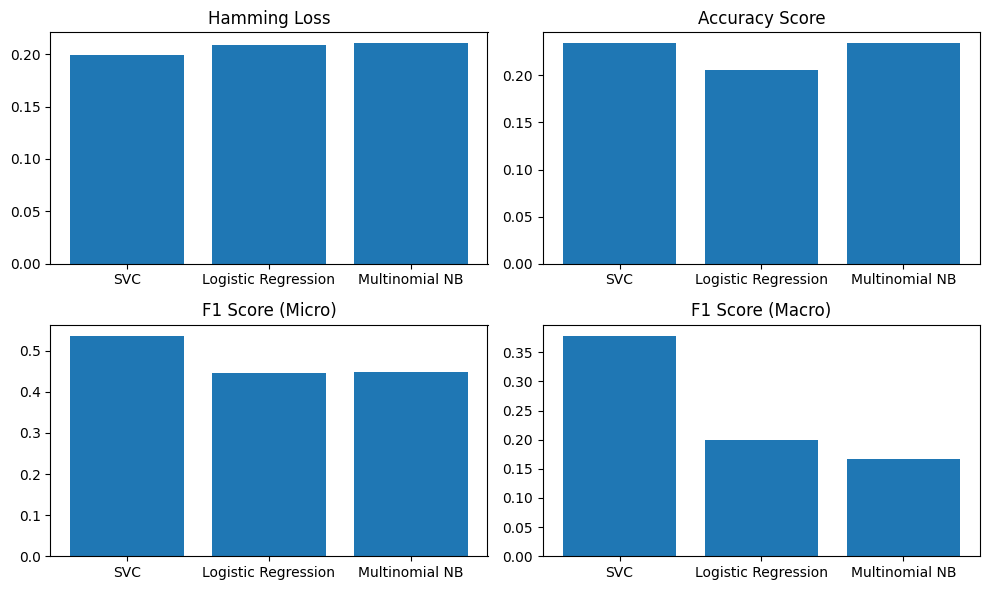

In [71]:
# Set custom font size
plt.rcParams.update({'font.size': 10})

classifiers = ['SVC', 'Logistic Regression', 'Multinomial NB']

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.bar(classifiers, hamming_losses)
plt.title('Hamming Loss')

plt.subplot(2, 2, 2)
plt.bar(classifiers, accuracy_scores)
plt.title('Accuracy Score')

plt.subplot(2, 2, 3)
plt.bar(classifiers, f1_scores_micro)
plt.title('F1 Score (Micro)')

plt.subplot(2, 2, 4)
plt.bar(classifiers, f1_scores_macro)
plt.title('F1 Score (Macro)')

plt.tight_layout()
plt.show()

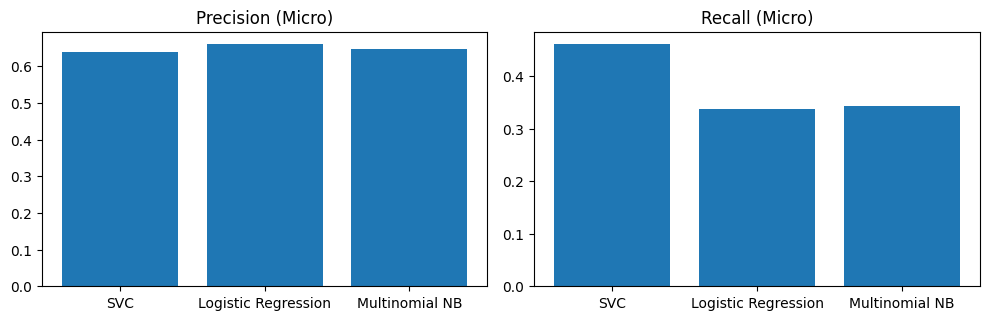

In [72]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.bar(classifiers, precision_micro)
plt.title('Precision (Micro)')

plt.subplot(2, 2, 2)
plt.bar(classifiers, recall_micro)
plt.title('Recall (Micro)')

plt.tight_layout()
plt.show()

In [73]:
# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ['Classifier', 'Hamming Loss', 'Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Micro', 'Recall Micro']

# Add data to the table
for clf, hl, acc, f1_micro, f1_macro, microprecision, microrecall in zip(classifiers, hamming_losses, accuracy_scores, f1_scores_micro, f1_scores_macro, precision_micro, recall_micro):
    table.add_row([clf, format(hl, '.2f'), format(acc, '.2f'), format(f1_micro, '.2f'), format(f1_macro, '.2f'), format(microprecision, '.2f'), format(microrecall, '.2f')])

# Print the table
print(table)

+---------------------+--------------+----------+----------+----------+-----------------+--------------+
|      Classifier     | Hamming Loss | Accuracy | F1 Micro | F1 Macro | Precision Micro | Recall Micro |
+---------------------+--------------+----------+----------+----------+-----------------+--------------+
|         SVC         |     0.20     |   0.23   |   0.54   |   0.38   |       0.64      |     0.46     |
| Logistic Regression |     0.21     |   0.21   |   0.45   |   0.20   |       0.66      |     0.34     |
|    Multinomial NB   |     0.21     |   0.23   |   0.45   |   0.17   |       0.65      |     0.34     |
+---------------------+--------------+----------+----------+----------+-----------------+--------------+


SVC performs best in general